In [187]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import OneHotEncoder
import eli5
import pickle
from IPython.display import display_html

In [2]:
def write_to_submission_file(predicted_labels, out_file, target='target', index_label='session_id'):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns = [target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [4]:
train_df = pd.read_csv(r'data/train_sessions.csv', index_col='session_id')
test_df = pd.read_csv(r'data/test_sessions.csv', index_col='session_id')

In [5]:
# Convert the time columns to datetime type from object
times = ['time%s' %i for i in range(1,11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# Sorting the data by time
train_df.sort_values(by='time1', inplace=True)

train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [6]:
sites = ['site%s' %i for i in range(1,11)]
train_df[sites].fillna(0).astype('int').to_csv('data/train_sessions_text.csv', sep=',', index=None, header=None)
test_df[sites].fillna(0).astype('int').to_csv('data/test_sessions_text.csv', sep=',', index=None, header=None)

In [7]:
with open(r"data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])

In [14]:
%%time

tf = TfidfVectorizer()

with open('data/train_sessions_text.csv') as inp_train_file:
    X_train_sites = tf.fit_transform(inp_train_file)
with open('data/test_sessions_text.csv') as inp_test_file:
    X_test_sites = tf.transform(inp_test_file)

Wall time: 7.31 s


In [15]:
X_train_sites.shape, X_test_sites.shape

((253561, 41592), (82797, 41592))

In [18]:
y_train = train_df['target'].astype('int')

In [22]:
time_split = TimeSeriesSplit(n_splits=10)

In [51]:
logit = LogisticRegression(C=1, solver='liblinear')

In [24]:
cv_scores1 = cross_val_score(logit, X_train_sites, y_train, scoring='roc_auc', cv=time_split, n_jobs=-1, verbose=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    7.1s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.7s finished


In [25]:
cv_scores1, cv_scores1.mean()

(array([0.79738066, 0.66527794, 0.87207069, 0.93336481, 0.84811885,
        0.88257794, 0.92296525, 0.86409586, 0.92640816, 0.91885051]),
 0.863111067215718)

In [52]:
logit.fit(X_train_sites, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [46]:
tf_feature_names = list(pd.Series(tf.get_feature_names()).astype('int').apply(lambda site: sites_dict.loc[site]).values.flatten())

In [53]:
eli5.show_weights(estimator=logit, feature_names=tf_feature_names)

Weight?,Feature
+6.430,cid-ed6c3e6a5c6608a4.users.storage.live.com
+5.778,youwatch.org
+5.668,www.banque-chalus.fr
+5.379,fr.glee.wikia.com
+4.616,vk.com
+4.589,www.cjn.justice.gouv.fr
+4.570,www.info-jeunes.net
+4.417,browser-update.org
+4.377,demotivateur.disqus.com
+4.280,www.audienceinsights.net


In [118]:
def train_and_predict(model, X_train, y_train, site_feature_names=tf_feature_names, 
                      new_feature_names=None, cv=time_split, scoring='roc_auc',submission_file_name='submission.csv'):
    
    cv_scores = cross_val_score(model, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1, verbose=True)
    print('CV scores: ', cv_scores)
    print('CV mean: {}, CV std: {}'.format(cv_scores.mean(), cv_scores.std()))
    model.fit(X_train, y_train)
    
    if new_feature_names:
        all_feature_names = site_feature_names + new_feature_names
    else:
        all_feature_names = site_feature_names
        
    display_html(eli5.show_weights(estimator=model, feature_names=all_feature_names))
    
    if new_feature_names:
        print(pd.DataFrame({'feature': new_feature_names,
                            'coeff': model.coef_.flatten()[-len(new_feature_names):]}))
    return cv_scores

In [68]:
cv_scores2 = train_and_predict(logit, X_train_sites, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.8s finished


CV scores:  [0.79738066 0.66527794 0.87207069 0.93336481 0.84811885 0.88257794
 0.92296525 0.86409586 0.92640816 0.91885051]
CV mean: 0.863111067215718, CV std: 0.07731424472855472


Weight?,Feature
+6.430,cid-ed6c3e6a5c6608a4.users.storage.live.com
+5.778,youwatch.org
+5.668,www.banque-chalus.fr
+5.379,fr.glee.wikia.com
+4.616,vk.com
+4.589,www.cjn.justice.gouv.fr
+4.570,www.info-jeunes.net
+4.417,browser-update.org
+4.377,demotivateur.disqus.com
+4.280,www.audienceinsights.net


In [75]:
session_start_hour = train_df['time1'].apply(lambda ts: ts.hour)

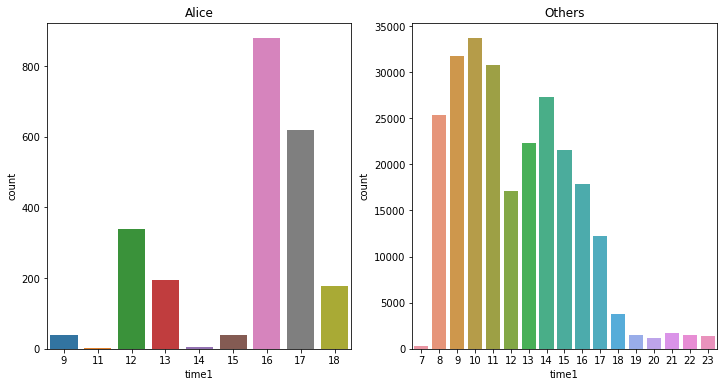

In [80]:
plt.subplots(1, 2, figsize = (12,6))

plt.subplot(1, 2, 1)
sns.countplot(session_start_hour[y_train==1])
plt.title('Alice');

plt.subplot(1, 2, 2)
sns.countplot(session_start_hour[y_train==0])
plt.title('Others');

In [86]:
morning = ((session_start_hour>=7) & (session_start_hour<=11))
noon = ((session_start_hour>=12) & (session_start_hour<=13))
afternoon = ((session_start_hour>=14) & (session_start_hour<=15))
evening = ((session_start_hour>=16) & (session_start_hour<=18))
night = ((session_start_hour>=19) & (session_start_hour<=23))

In [136]:
def add_time_features(times, X_sparse, add_hour=True):
    hour = times['time1'].apply(lambda ts: ts.hour)
    morning = ((hour>=7) & (hour<=11)).astype('int').values.reshape(-1,1)
    noon = ((hour>=12) & (hour<=15)).astype('int').values.reshape(-1,1)
    afternoon = ((hour>=16) & (hour<=18)).astype('int').values.reshape(-1,1)
    evening = ((hour>=19) & (hour<=23)).astype('int').values.reshape(-1,1)
    night = ((hour>=0) & (hour<=6)).astype('int').values.reshape(-1,1)
    
    objects_to_hstack = [X_sparse, morning, noon, afternoon, evening, night]
    feature_names = ['morning', 'noon', 'afternoon', 'evening', 'night']
    
    if add_hour:
        objects_to_hstack.append(hour.values.reshape(-1,1)/24)
        feature_names.append('hour')
    
    X = hstack(objects_to_hstack)
    return X, feature_names

In [137]:
%%time
X_train_with_times1, new_feat_names = add_time_features(train_df[times], X_train_sites)
X_test_with_times1, _ = add_time_features(test_df[times], X_test_sites)

Wall time: 3.84 s


In [138]:
cv_scores3 = train_and_predict(logit, X_train_with_times1, y_train, new_feature_names=new_feat_names)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.7s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.7s finished


CV scores:  [0.62485666 0.80477817 0.96704514 0.96695866 0.91554743 0.97867029
 0.91673182 0.95052316 0.96649196 0.97290022]
CV mean: 0.9064503499844015, CV std: 0.10598698077790616


Weight?,Feature
+6.042,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.971,www.express.co.uk
+4.929,www.banque-chalus.fr
+4.570,youwatch.org
+4.492,www.info-jeunes.net
+4.283,vk.com
+4.237,www.melty.fr
+4.201,demotivateur.disqus.com
+4.082,www.audienceinsights.net
+3.965,fr.glee.wikia.com


     feature     coeff
0    morning -3.994475
1       noon  0.038705
2  afternoon  3.107693
3    evening -0.893909
4      night  0.000000
5       hour -7.470333


In [139]:
%%time
X_train_with_times1, new_feat_names = add_time_features(train_df[times], X_train_sites, add_hour=False)
X_test_with_times1, _ = add_time_features(test_df[times], X_test_sites, add_hour=False)

Wall time: 2.52 s


In [140]:
cv_scores4 = train_and_predict(logit, X_train_with_times1, y_train, new_feature_names=new_feat_names)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.6s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.9s finished


CV scores:  [0.61372363 0.77895537 0.96989376 0.97040076 0.90215272 0.97826935
 0.92640771 0.9456515  0.9732794  0.97514972]
CV mean: 0.9033883929153607, CV std: 0.11236639106360223


Weight?,Feature
+6.140,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.996,www.express.co.uk
+4.956,www.banque-chalus.fr
+4.599,www.info-jeunes.net
+4.565,youwatch.org
+4.366,vk.com
+4.281,www.melty.fr
+4.280,demotivateur.disqus.com
+4.049,www.audienceinsights.net
+4.031,fr.glee.wikia.com


     feature     coeff
0    morning -3.434831
1       noon -0.568442
2  afternoon  1.459397
3    evening -2.697611
4      night  0.000000


In [141]:
logit.fit(X_train_with_times1, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [142]:
y_pred = logit.predict_proba(X_test_with_times1)[:,1]

In [145]:
write_to_submission_file(y_pred, 'data/subm1_05_03.csv')

In [156]:
day_of_week = train_df['time1'].apply(lambda ts: ts.dayofweek)

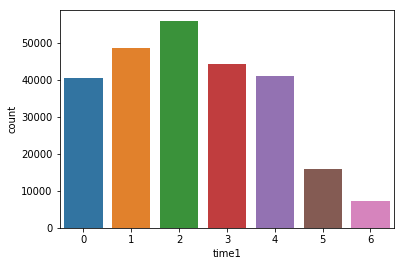

In [158]:
sns.countplot(day_of_week);

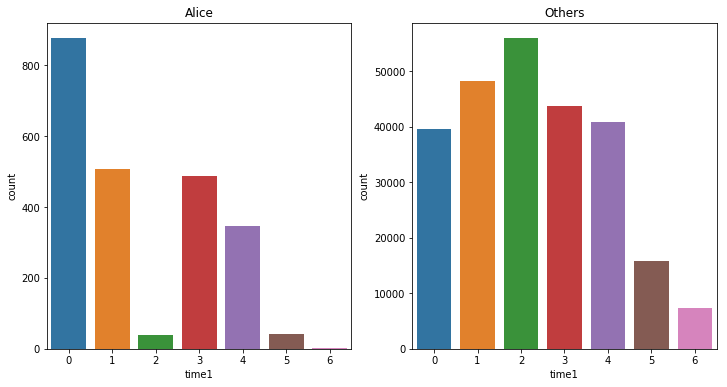

In [159]:
plt.subplots(1, 2, figsize = (12,6))

plt.subplot(1, 2, 1)
sns.countplot(day_of_week[y_train==1])
plt.title('Alice');

plt.subplot(1, 2, 2)
sns.countplot(day_of_week[y_train==0])
plt.title('Others');

In [168]:
ohe = OneHotEncoder(sparse = False)
X_train_dow = ohe.fit_transform(train_df['time1'].apply(lambda ts: ts.dayofweek).values.reshape(-1,1))
X_test_dow = ohe.transform(test_df['time1'].apply(lambda ts: ts.dayofweek).values.reshape(-1,1))

C:\Users\Shubham\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [171]:
new_dow_features = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [178]:
new_feat_names_dow = new_feat_names + new_dow_features

In [181]:
X_train_time_dow = hstack([X_train_with_times1, X_train_dow])
X_test_time_dow = hstack([X_test_with_times1, X_test_dow])

In [182]:
cv_scores5 = train_and_predict(logit, X_train_time_dow, y_train, new_feature_names=new_feat_names_dow)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   39.7s remaining:   26.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   42.9s finished


CV scores:  [0.61943835 0.86361831 0.91805922 0.97671399 0.9169869  0.98440486
 0.91096891 0.94553069 0.81698708 0.98078475]
CV mean: 0.8933493055188293, CV std: 0.10432197258567928


Weight?,Feature
+6.146,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.976,www.express.co.uk
+4.717,www.banque-chalus.fr
+4.675,www.info-jeunes.net
+4.324,demotivateur.disqus.com
+4.286,youwatch.org
+4.221,www.melty.fr
+4.174,vk.com
+4.028,www.audienceinsights.net
+3.958,www.clermont-filmfest.com


      feature     coeff
0     morning -3.355495
1        noon -0.542014
2   afternoon  1.485789
3     evening -2.833318
4       night  0.000000
5      Monday  0.890721
6     Tuesday  0.057154
7   Wednesday -2.739346
8    Thursday  0.085458
9      Friday  0.062846
10   Saturday -0.625186
11     Sunday -2.976684


In [183]:
y_pred = logit.predict_proba(X_test_time_dow)[:,1]

In [184]:
write_to_submission_file(y_pred, 'data/subm2_05_03.csv')

In [188]:
c_values = np.logspace(-2, 2, 10)

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values}, scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=1)

In [189]:
%%time

logit_grid_searcher.fit(X_train_time_dow, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished


Wall time: 2min 15s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1.00000e-02, 2.78256e-02, 7.74264e-02, 2.15443e-01, 5.99484e-01,
       1.66810e+00, 4.64159e+00, 1.29155e+01, 3.59381e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [192]:
logit_grid_searcher.best_params_, logit_grid_searcher.best_score_

({'C': 35.93813663804626}, 0.8974711315003417)

In [197]:
y_pred = logit_grid_searcher.predict_proba(X_test_time_dow)[:,1]

In [198]:
write_to_submission_file(y_pred, 'data/subm3_05_03.csv')